In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import stark
import stark.utilities as utilities
import sklearn

ModuleNotFoundError: No module named 'utilities'

## Loading the data and basic filtering 

In [2]:
dataset = "StereoSeq"
INDIR = "/mnt/geofflab/st_denoising_data/adata/"

# Input files
ADATA_FILE_E9_5 = "Mouse_embryo_E9_5.h5ad"

# Read data
#adata = sc.read_h5ad(os.path.join(INDIR,ADATA_FILE))
adata = sc.read_h5ad(os.path.join(INDIR,ADATA_FILE_E9_5))

In [3]:
adata.X = adata.layers['count']
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
sc.pp.filter_genes(adata, min_cells=50)

adata

AnnData object with n_obs × n_vars = 5503 × 15717
    obs: 'annotation', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'annotation_colors'
    obsm: 'spatial'
    layers: 'count'

## Downsampling reads to get a noisier version of adata

In [7]:
random_state = 500
target_reads_per_pixel = 100
target_total_reads = target_reads_per_pixel * adata.n_obs

downsampled_adata = sc.pp.downsample_counts(adata, total_counts=target_total_reads, random_state=random_state, copy=True)
downsampled_adata

AnnData object with n_obs × n_vars = 5503 × 15717
    obs: 'annotation', 'timepoint', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_counts'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'annotation_colors'
    obsm: 'spatial'
    layers: 'count'

In [8]:
# average reads per pixel
downsampled_adata.X.sum()/downsampled_adata.n_obs

100.0

## Denoising with STARK

Computing spatial length scale.
Success criterion achieved:
Ave num neighbours = 7.669
--------------------------------------------------------------
Computing suitable hyperparameters.
Bisection search for overall regularization strength ---------------------------
Converged and success criterion achieved!
-------------------------------------------------------------------------------
Running block coordinate descent.
Done iteration:  0
Done iteration:  1
Done iteration:  2
Done iteration:  3
Done iteration:  4
Done iteration:  5
Done iteration:  6
------------------------------------------------------------


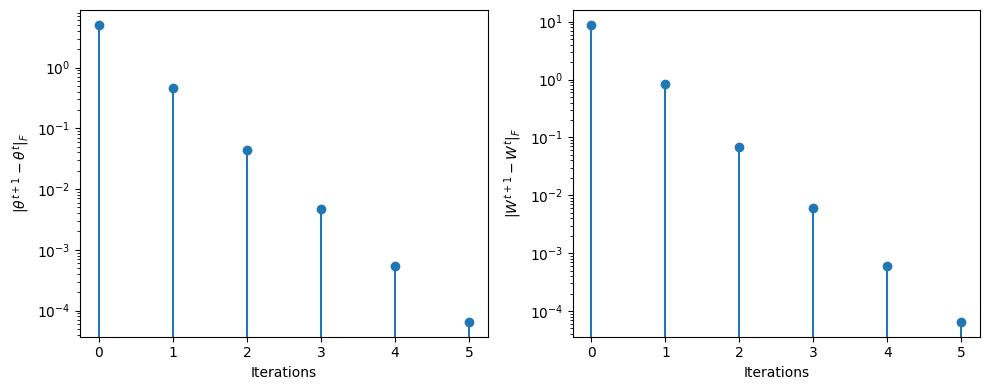

In [9]:

reads_pixelwise = np.array(downsampled_adata.X.sum(axis=1)).squeeze() # Get pixelwise reads from the noisy counts matrix.

sc.pp.normalize_total(downsampled_adata, target_sum=1.0) # Normalize the gene expression vectors to sum to 1.

output = stark.stark_denoise(downsampled_adata, reads_pixelwise, num_adaptive_iter=7, convergence_plots=True)


## Computing the performance metrics

In [10]:
# Relative error

orig_counts_normalized = utilities.normalize_matrix(adata.X.toarray()) # Normalized ground truth counts matrix.

relative_error = utilities.relative_error_numpy(orig_counts_normalized, output["denoised_matrix"])


Relative error = 0.3718307918502235


Label transfer accuracy on denoised:  0.8946029438488098


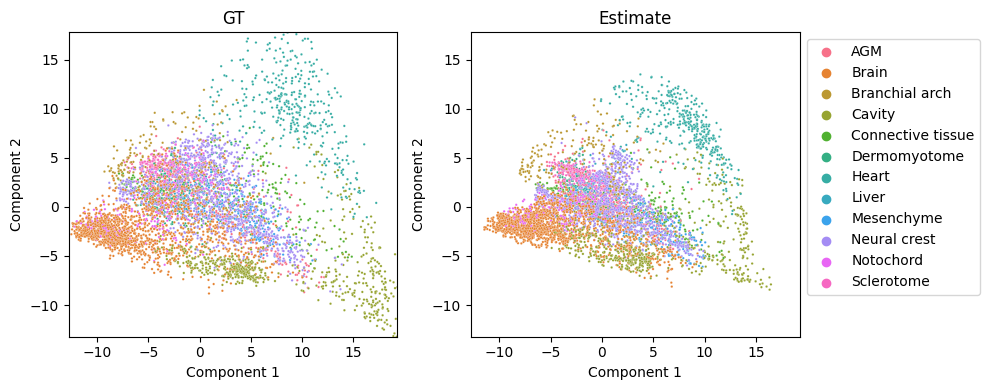

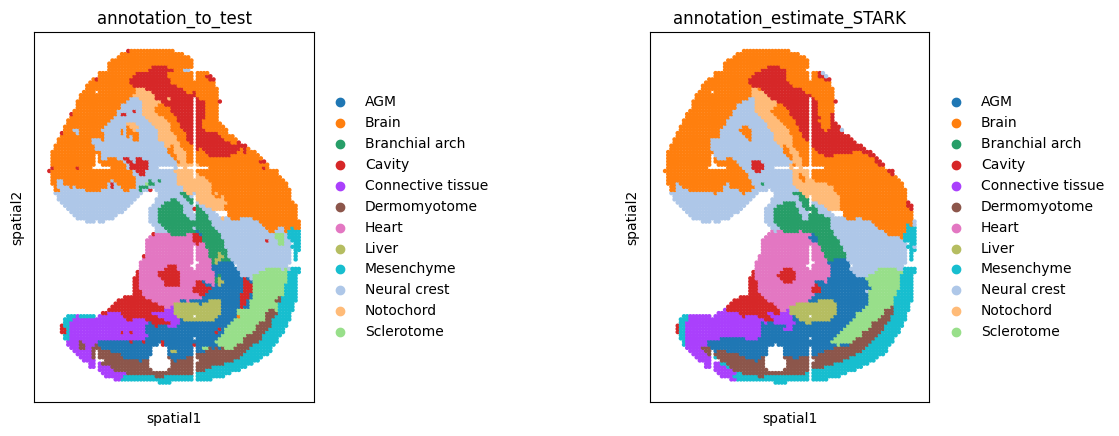

In [11]:
# Label transfer accuracy

num_pcs = 30

classifier_pipe = sklearn.pipeline.make_pipeline(sklearn.decomposition.PCA(n_components=num_pcs, random_state=0),
                                      sklearn.neighbors.KNeighborsClassifier(n_neighbors=9, weights='uniform', p=2))


label_transfer_results = utilities.compute_label_transfer_accuracy(adata_orig=adata, adata_reference=adata, denoised_matrix=output["denoised_matrix"], 
                                                classifier_pipe=classifier_pipe, method_name='STARK', pretrained=False, 
                                                compute_transferred_annotations_on_orig=False, spot_size=2, plotting=True, 
                                                fullfile_classification_plot=None, fullfile_pca_plot=None)

In [12]:
# kNN overlap

num_pcs = 30
k_val = 50

kNN_overlap = utilities.compute_kNN_overlap(adata_orig=adata, denoised_matrix=output["denoised_matrix"], k_val=k_val, num_pcs=num_pcs)
print("kNN overlap = {}".format(kNN_overlap))

kNN overlap = 23.78302743957841
